In [1]:
import sqlite3
import pandas as pd
import math
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib as plt

from sklearn.linear_model import LinearRegression

In [2]:
connection = sqlite3.connect('Northwind_small.sqlite')
cursor = connection.cursor()

In [3]:
def sql_select_to_df(SQL_COMMAND, cursor=cursor):
    """returns output of SQL command in dataframe format"""
    results = cursor.execute(SQL_COMMAND).fetchall()
    df = pd.DataFrame(results)
    df.columns = [i[0] for i in cursor.description]
    return df

In [4]:
categoryNames = sql_select_to_df("""select * from Category""")
categoryNames

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


In [5]:
orderDetail_df = sql_select_to_df("""select * from [OrderDetail] OD
                                     JOIN [Product] P ON P.ID == OD.ProductID;""")

orderDetail_df = orderDetail_df.drop(orderDetail_df.columns[0], axis=1)
orderDetail_df = orderDetail_df.loc[:,~orderDetail_df.columns.duplicated()]
orderDetail_df

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248,11,14.00,12,0.00,Queso Cabrales,5,4,1 kg pkg.,22,30,30,0
1,10248,42,9.80,10,0.00,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,26,0,0,1
2,10248,72,34.80,5,0.00,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,14,0,0,0
3,10249,14,18.60,9,0.00,Tofu,6,7,40 - 100 g pkgs.,35,0,0,0
4,10249,51,42.40,40,0.00,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,20,0,10,0
5,10250,41,7.70,10,0.00,Jack's New England Clam Chowder,19,8,12 - 12 oz cans,85,0,10,0
6,10250,51,42.40,35,0.15,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,20,0,10,0
7,10250,65,16.80,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,76,0,0,0
8,10251,22,16.80,6,0.05,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,104,0,25,0
9,10251,57,15.60,15,0.05,Ravioli Angelo,26,5,24 - 250 g pkgs.,36,0,20,0


In [6]:
revenues = orderDetail_df.Quantity.values * orderDetail_df.UnitPrice.values
orderDetail_df['Revenue'] = revenues

discounts = list(orderDetail_df.Discount.values)

def get_discount_multiplier(discount):
    newlist = []
    
    for d in discount:
        newlist.append(1-d)
    
    return newlist

discount_multipliers = get_discount_multiplier(discounts)
discount_multipliers
orderDetail_df['DiscountMultipliers'] = discount_multipliers

orderDetail_df['DiscountedPrice'] = orderDetail_df.UnitPrice.values * orderDetail_df.DiscountMultipliers.values
orderDetail_df['Revenue_final'] = orderDetail_df.DiscountedPrice.values * orderDetail_df.Quantity.values

orderDetail_df

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Revenue,DiscountMultipliers,DiscountedPrice,Revenue_final
0,10248,11,14.00,12,0.00,Queso Cabrales,5,4,1 kg pkg.,22,30,30,0,168.00,1.00,14.0000,168.0000
1,10248,42,9.80,10,0.00,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,26,0,0,1,98.00,1.00,9.8000,98.0000
2,10248,72,34.80,5,0.00,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,14,0,0,0,174.00,1.00,34.8000,174.0000
3,10249,14,18.60,9,0.00,Tofu,6,7,40 - 100 g pkgs.,35,0,0,0,167.40,1.00,18.6000,167.4000
4,10249,51,42.40,40,0.00,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,20,0,10,0,1696.00,1.00,42.4000,1696.0000
5,10250,41,7.70,10,0.00,Jack's New England Clam Chowder,19,8,12 - 12 oz cans,85,0,10,0,77.00,1.00,7.7000,77.0000
6,10250,51,42.40,35,0.15,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,20,0,10,0,1484.00,0.85,36.0400,1261.4000
7,10250,65,16.80,15,0.15,Louisiana Fiery Hot Pepper Sauce,2,2,32 - 8 oz bottles,76,0,0,0,252.00,0.85,14.2800,214.2000
8,10251,22,16.80,6,0.05,Gustaf's Knäckebröd,9,5,24 - 500 g pkgs.,104,0,25,0,100.80,0.95,15.9600,95.7600
9,10251,57,15.60,15,0.05,Ravioli Angelo,26,5,24 - 250 g pkgs.,36,0,20,0,234.00,0.95,14.8200,222.3000


In [7]:
changs = orderDetail_df.loc[orderDetail_df['ProductName'] == 'Chang']

In [8]:
product_quantities = orderDetail_df.groupby(['CategoryId','ProductName']).Quantity.sum()
cat1_quantities = product_quantities[1]
cat2_quantities = product_quantities[2]
cat3_quantities = product_quantities[3]
cat4_quantities = product_quantities[4]
cat5_quantities = product_quantities[5]
cat6_quantities = product_quantities[6]
cat7_quantities = product_quantities[7]
cat8_quantities = product_quantities[8]

In [9]:
product_prices = orderDetail_df.groupby(['CategoryId','ProductName']).DiscountedPrice.mean()
cat1_prices = product_prices[1]
cat2_prices = product_prices[2]
cat3_prices = product_prices[3]
cat4_prices = product_prices[4]
cat5_prices = product_prices[5]
cat6_prices = product_prices[6]
cat7_prices = product_prices[7]
cat8_prices = product_prices[8]

### Cheese

2.2234375 1577
ProductName
Camembert Pierrot            30.120000
Flotemysost                  18.868810
Geitost                       2.223438
Gorgonzola Telino            10.928922
Gudbrandsdalsost             30.832258
Mascarpone Fabioli           28.586667
Mozzarella di Giovanni       31.313947
Queso Cabrales               18.505789
Queso Manchego La Pastora    34.498571
Raclette Courdavault         48.766667
Name: DiscountedPrice, dtype: float64


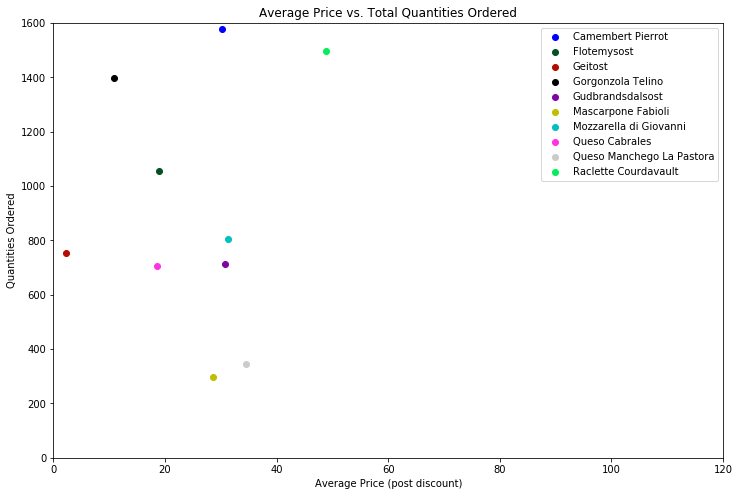

In [10]:
x = tuple(cat4_prices.values)
y = tuple(cat4_quantities.values)

print((x[2]), y[0])
print(cat4_prices)
plt.pyplot.figure(figsize = (12,8))
plt.pyplot.scatter(x[0],y[0], label = 'Camembert Pierrot', c='b', marker = "o")
plt.pyplot.scatter(x[1],y[1], label = 'Flotemysost', c='#055020', marker = "o")
plt.pyplot.scatter(x[2],y[2], label = 'Geitost', c='#B40C01', marker = "o")
plt.pyplot.scatter(x[3],y[3], label = 'Gorgonzola Telino', c='k', marker = "o")
plt.pyplot.scatter(x[4],y[4], label = 'Gudbrandsdalsost', c='#8104A2', marker = "o")
plt.pyplot.scatter(x[5],y[5], label = 'Mascarpone Fabioli', c='y', marker = "o")
plt.pyplot.scatter(x[6],y[6], label = 'Mozzarella di Giovanni', c='c', marker = "o")
plt.pyplot.scatter(x[7],y[7], label = 'Queso Cabrales', c='#FF33E3', marker = "o")
plt.pyplot.scatter(x[8],y[8], label = 'Queso Manchego La Pastora', c='#CBCBCB', marker = "o")
plt.pyplot.scatter(x[9],y[9], label = 'Raclette Courdavault', c='#03EE58', marker = "o")

plt.pyplot.ylabel("Quantities Ordered")
plt.pyplot.xlabel("Average Price (post discount)")
plt.pyplot.title("Average Price vs. Total Quantities Ordered")

plt.pyplot.xlim(0,120)
plt.pyplot.ylim(0,1600)

plt.pyplot.legend(fontsize=10)
plt.pyplot.show()

### Meats

34.225135135135126 978
ProductName
Alice Mutton                34.225135
Mishi Kobe Niku             83.808000
Perth Pasties               29.023667
Pâté chinois                20.720000
Thüringer Rostbratwurst    108.383969
Tourtière                    6.296250
Name: DiscountedPrice, dtype: float64


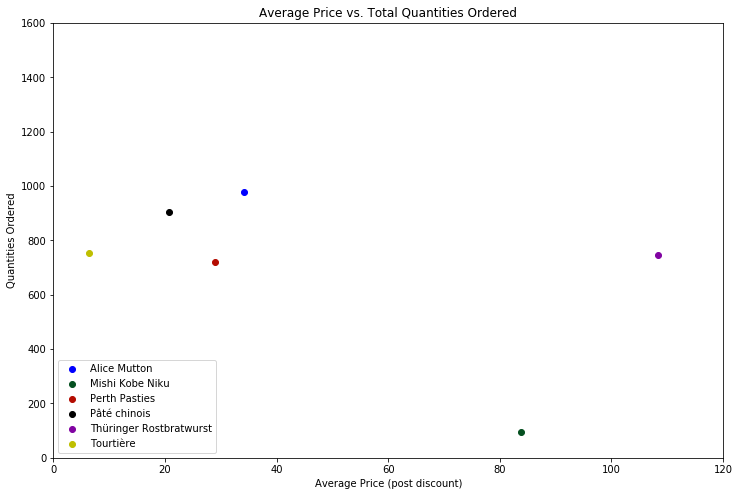

In [11]:
x1 = tuple(cat6_prices.values)
y1 = tuple(cat6_quantities.values)

print((x1[0]), y1[0])
print(cat6_prices)
#print(cat2_quantities)
plt.pyplot.figure(figsize = (12,8))
plt.pyplot.scatter(x1[0],y1[0], label = 'Alice Mutton', c='b', marker = "o")
plt.pyplot.scatter(x1[1],y1[1], label = 'Mishi Kobe Niku', c='#055020', marker = "o")
plt.pyplot.scatter(x1[2],y1[2], label = 'Perth Pasties', c='#B40C01', marker = "o")
plt.pyplot.scatter(x1[3],y1[3], label = 'Pâté chinois', c='k', marker = "o")
plt.pyplot.scatter(x1[4],y1[4], label = 'Thüringer Rostbratwurst', c='#8104A2', marker = "o")
plt.pyplot.scatter(x1[5],y1[5], label = 'Tourtière', c='y', marker = "o")

plt.pyplot.ylabel("Quantities Ordered")
plt.pyplot.xlabel("Average Price (post discount)")
plt.pyplot.title("Average Price vs. Total Quantities Ordered")

plt.pyplot.xlim(0,120)
plt.pyplot.ylim(0,1600)
plt.pyplot.legend(fontsize=10, loc='lower left')
plt.pyplot.show()

### Produce

34.225135135135126 978
ProductName
Longlife Tofu                       8.330769
Manjimup Dried Apples              47.998974
Rössle Sauerkraut                  40.346061
Tofu                               19.857614
Uncle Bob's Organic Dried Pears    28.396552
Name: DiscountedPrice, dtype: float64


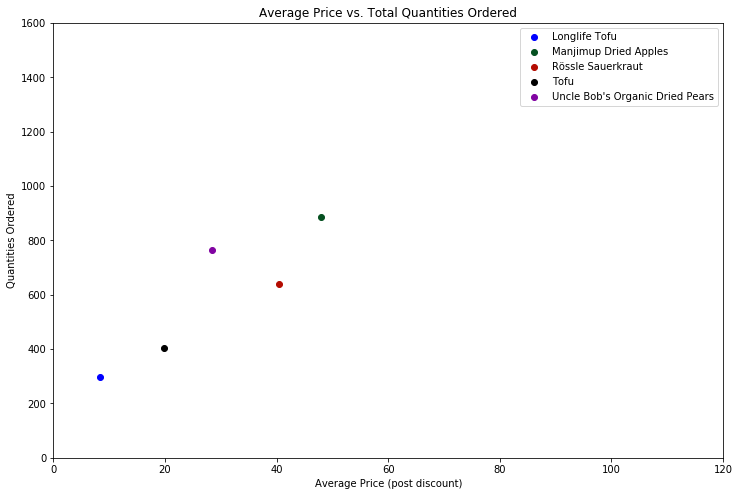

In [12]:
x2 = tuple(cat7_prices.values)
y2 = tuple(cat7_quantities.values)

print((x1[0]), y1[0])
print(cat7_prices)
#print(cat2_quantities)
plt.pyplot.figure(figsize = (12,8))
plt.pyplot.scatter(x2[0],y2[0], label = 'Longlife Tofu', c='b', marker = "o")
plt.pyplot.scatter(x2[1],y2[1], label = 'Manjimup Dried Apples', c='#055020', marker = "o")
plt.pyplot.scatter(x2[2],y2[2], label = 'Rössle Sauerkraut', c='#B40C01', marker = "o")
plt.pyplot.scatter(x2[3],y2[3], label = 'Tofu', c='k', marker = "o")
plt.pyplot.scatter(x2[4],y2[4], label = 'Uncle Bob\'s Organic Dried Pears', c='#8104A2', marker = "o")

plt.pyplot.ylabel("Quantities Ordered")
plt.pyplot.xlabel("Average Price (post discount)")
plt.pyplot.title("Average Price vs. Total Quantities Ordered")

plt.pyplot.xlim(0,120)
plt.pyplot.ylim(0,1600)

plt.pyplot.legend(fontsize=10)
plt.pyplot.show()

9.35 328
ProductName
Aniseed Syrup                        9.350000
Chef Anton's Cajun Seasoning        19.096000
Chef Anton's Gumbo Mix              18.182750
Genen Shouyu                        14.208333
Grandma's Boysenberry Spread        23.395833
Gula Malacca                        17.073437
Louisiana Fiery Hot Pepper Sauce    18.516328
Louisiana Hot Spiced Okra           14.875000
Northwoods Cranberry Sauce          36.307692
Original Frankfurter grüne Soße     11.474211
Sirop d'érable                      25.804375
Vegie-spread                        39.245294
Name: DiscountedPrice, dtype: float64


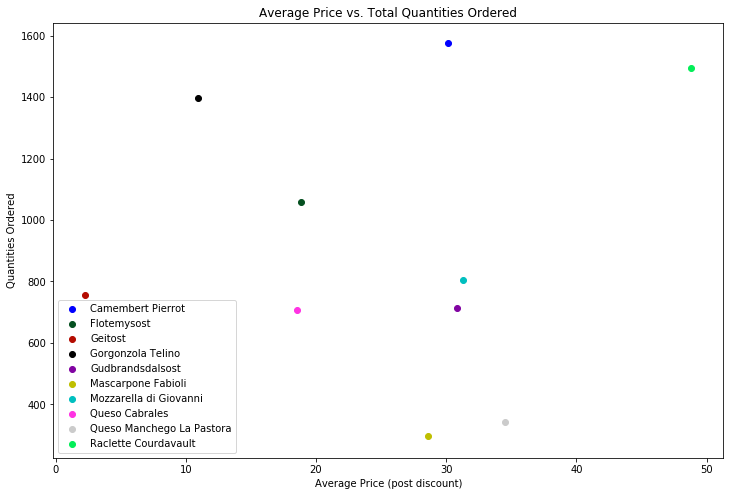

In [15]:
x3 = tuple(cat2_prices.values)
y3 = tuple(cat2_quantities.values)

print((x3[0]), y3[0])
print(cat2_prices)
#print(cat2_quantities)
plt.pyplot.figure(figsize = (12,8))
plt.pyplot.scatter(x[0],y[0], label = 'Camembert Pierrot', c='b', marker = "o")
plt.pyplot.scatter(x[1],y[1], label = 'Flotemysost', c='#055020', marker = "o")
plt.pyplot.scatter(x[2],y[2], label = 'Geitost', c='#B40C01', marker = "o")
plt.pyplot.scatter(x[3],y[3], label = 'Gorgonzola Telino', c='k', marker = "o")
plt.pyplot.scatter(x[4],y[4], label = 'Gudbrandsdalsost', c='#8104A2', marker = "o")
plt.pyplot.scatter(x[5],y[5], label = 'Mascarpone Fabioli', c='y', marker = "o")
plt.pyplot.scatter(x[6],y[6], label = 'Mozzarella di Giovanni', c='c', marker = "o")
plt.pyplot.scatter(x[7],y[7], label = 'Queso Cabrales', c='#FF33E3', marker = "o")
plt.pyplot.scatter(x[8],y[8], label = 'Queso Manchego La Pastora', c='#CBCBCB', marker = "o")
plt.pyplot.scatter(x[9],y[9], label = 'Raclette Courdavault', c='#03EE58', marker = "o")

plt.pyplot.ylabel("Quantities Ordered")
plt.pyplot.xlabel("Average Price (post discount)")
plt.pyplot.title("Average Price vs. Total Quantities Ordered")

#plt.pyplot.xlim(0,120)
#plt.pyplot.ylim(0,1600)

plt.pyplot.legend(fontsize=10)
plt.pyplot.show()